## Scene simulator
- Copies code from PSF_simulator notebook (1st block)
- Copies code from ETC_v1.5 notebook (2nd block)
- Should modify notebooks to allow importing of ETC/PSF tools
- Path to atlas model and pandora kernel directories specified in PSF and ETC blocks
- Total flux computed from ETC is just a sum; need to update

### Copied from PSF_simulator

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from skimage.transform import downscale_local_mean, resize

from scipy.io import loadmat
from scipy.signal import fftconvolve

from photutils.aperture import CircularAperture,aperture_photometry
from photutils.centroids import centroid_com

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm.notebook import trange

psf_dir = '/Users/james/poet-main/scene_sim/pandora/Kernels/'
psf_names = ['Pandora_nir_20210602_trefoil.mat']

class ModelPars:
    """Default Model Parameters
    """

    nplanetmax=9 #code is hardwired to have upto 9 transiting planets.
    #default parameters -- these will cause the program to end quickly
    tstart=0.0 #start time (days)
    tend=1.0 #end time (days)
    iframe=2 #number of frames used to generate exposure time (needed for pointing jitter)
    exptime=1 #exposure time (s)
    deadtime=0.0 #dead time (s)
    modelfile='null' #stellar spectrum file name
    nmodeltype=2 #stellar spectrum type. 1=BT-Settl, 2=Atlas-9+NL limbdarkening
    rvstar=0.0 #radial velocity of star (km/s)
    vsini=0.0 #projected rotation of star (km/s)
    pmodelfile=[None]*nplanetmax #file with Rp/Rs values
    pmodeltype=[None]*nplanetmax #Type of planet file
    emisfile=[None]*nplanetmax #file with emission spectrum
    ttvfile=[None]*nplanetmax #file with O-C measurements
    #nplanet is tracked by pmodelfile.
    nplanet=0 #number of planets -- default is no planets - you will get staronly sim.
    sol=np.zeros(nplanetmax*8+1)
    sol[0]=1.0 #mean stellar density [g/cc]
    xout=256  #x-axis
    xpad=10    #padding to deal with convolution fall-off
    ypad=10    #padding to deal with convolution fall-off
    yout=256   #y-axis
    noversample=2 #oversampling
    gain=1.6 # electronic gain [e-/adu]
    saturation=65536.0 #saturation
    jitter_dis=1.0 #pointing jitter in dispersion axis [pixels, rms]
    jitter_spa=1.0 #pointing jitter in spatial axis [pixels, rms]
    readnoise=8.0 #readnoise electrons
    gain=6.1 #e-/ADU

def addflux2pix(px,py,pixels,fmod):
    """Usage: pixels=addflux2pix(px,py,pixels,fmod)

    Drizel Flux onto Pixels using a square PSF of pixel size unity
    px,py are the pixel position (integers)
    fmod is the flux calculated for (px,py) pixel
        and it has the same length as px and py
    pixels is the image.
    """

    xmax = pixels.shape[0] #Size of pixel array
    ymax = pixels.shape[1]

    pxmh = px-0.5 #location of reference corner of PSF square
    pymh = py-0.5

    dx = np.floor(px+0.5)-pxmh
    dy = np.floor(py+0.5)-pymh

    # Supposing right-left as x axis and up-down as y axis:
    # Lower left pixel
    npx = int(pxmh) #Numpy arrays start at zero
    npy = int(pymh)

    #print('n',npx,npy)
    
    #if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
    #    pixels[npx,npy]=pixels[npx,npy]+fmod
    
    if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
        pixels[npx,npy]=pixels[npx,npy]+fmod*dx*dy

    #Same operations are done for the 3 pixels other neighbouring pixels

    # Lower right pixel
    npx = int(pxmh)+1 #Numpy arrays start at zero
    npy = int(pymh)
    if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
        pixels[npx,npy]=pixels[npx,npy]+fmod*(1.0-dx)*dy

    # Upper left pixel
    npx = int(pxmh) #Numpy arrays start at zero
    npy = int(pymh)+1
    if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
        pixels[npx,npy]=pixels[npx,npy]+fmod*dx*(1.0-dy)

    # Upper right pixel
    npx = int(pxmh)+1 #Numpy arrays start at zero
    npy = int(pymh)+1
    if (npx >= 0) & (npx < xmax) & (npy >= 0) & (npy < ymax) :
        pixels[npx,npy]=pixels[npx,npy]+fmod*(1.0-dx)*(1.0-dy)
    
    return pixels;

def gauss2d(x,y,sig):
    g=1/(2*np.pi*sig*sig) * np.exp(-(x*x+y*y)/(2*sig*sig))
    return g

def gen_unconv_image(pars,starmodel_flux,xcoo,ycoo):

    xpad=pars.xpad*pars.noversample
    ypad=pars.ypad*pars.noversample
    #array to hold synthetic image
    xmax=pars.xout*pars.noversample+xpad*2
    ymax=pars.yout*pars.noversample+ypad*2

    pixels=np.zeros((xmax,ymax))
    
    i=xcoo*pars.noversample
    j=ycoo*pars.noversample
    
    pixels=addflux2pix(i,j,pixels,starmodel_flux)
    
    return pixels

def readkernels(psf_dir,psf_names):
    """Reads in PSFs from Matlab file and resamples to match pixel grid of simulation.
    
    Usage: psf=readkernels(psf_dir,psf_names)
    
        Inputs:
            psf_dir - location of PSFs
            psf_names - names of the PSF files to read in.  Order should match 'psf_wv' array
          
        Outputs:
            psf - array of PSFs.
    """
    
    detector_pixscale=18 #detector pixel size (microns)  ***This should be a model parameter***
    
    psf=[]
    for name in psf_names:
        mat_dict=loadmat(psf_dir+psf_names[0]) #read in PSF from Matlab file
        
        psf_native=mat_dict['psf']
        dx_scale=mat_dict['dx'] #scale in micron/pixel of the PSF
        x_scale=int(psf_native.shape[0]*dx_scale/detector_pixscale*pars.noversample) #This gives the PSF size in pixels 
        y_scale=int(psf_native.shape[1]*dx_scale/detector_pixscale*pars.noversample) #This gives the PSF size in pixels 
        
        #We now resize the PSF from psf.shape to x_scale,yscale
        psf_resize=resize(psf_native,(x_scale,y_scale))
        psf.append(psf_resize)
        
        #plt.imshow(psf_resize,norm=LogNorm())
        #plt.show()
        
    return psf

### Copied from ETC_v1.5

In [2]:
# %matplotlib notebook
from ipywidgets import *
import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
import statistics
import os
from astropy.io import fits #To read in FITS files and tables
import matplotlib



c = 2.998e8 #speed of light (m/s)
h = 6.626e-34 #Planck m^2 kg/s
Pi= np.pi*1.0 #define Pi
Rsun=695700000.0  # Radius of Sun (m)
zero_point = 25.6884
tput = 0.18 
aperture = 0.15
aperture2 = 2.4
gain = 6.1 #Photons needed for a single electron event 
grid_dir="/Users/james/poet-main/ck04models/" #base directory for ATLAS models

def changeunits(flux):
    """
    Changes the units of flux from ergs/s/cm^2/nm to watts/m^2/nm. 
    Additional scale factor is used to match GAIA magnitude values.
    """
    try:
        fluxScaled = flux * 1e-7/(0.0001)*(4*np.pi)*6.898196982008417e-19
        return fluxScaled
    except: 
        return 0
    
    
def changeunitsA(flux, wavelength):
    """
    changes the units of flux from ergs/s/cm^2/A to watts/m^s/nm
    """
    newWavelength = wavelength /10
    fluxScaled = flux *1e-7/(0.0001)*10*6.898196982008417e-19
    
    return fluxScaled, newWavelength
    
    
def numericIntegration(x,y):
    """
    Function used to numerically integrate a function.
    
    Inputs:
        x: array of the x values of the curve
        y: array of the y values of the curve
        
    Output:
        total: Value of the numeric integration.
    """
    total = 0  #Add all of the areas to this to get the final integration 
    for i in range(len(x)-1):
        width = x[i+1]-x[i]
        height = y[i] + (y[i+1]-y[i])/2
        area = width*height
        total += area
    return total

##############################################################################################
###  Code to read in the ATLAS star data used for the ETC
##############################################################################################




def getStarData(temperature, metallicity, logG):
    """
    Reads in star data from atlas directory, according to temperature, metallicity, and log(G) values.
    
    Inputs: 
        temperature: Temperature of the reference star in kelvin. Type: float
        metallicity: Metallicity of the reference star. Accepted inputs. 'p/m00','p/m05','p/m10','p/m15','p/m20'
                     p is plus, m is minus.
        logG: log(G) value for the reference star. Type: g00,g05,g10,g15,g20,g25,g30,g35,g40,g45,g50
    
    Outputs: 
        starFlux: flux of the reference star in units watts/m^2/nm. Type: array
        starWavelength: Wavelength of the reference star in nm. Type: array
    """


    mh=metallicity #metallicity 
    teff=temperature #3500 -- 13000 in steps of 250 K are available

    specfile=grid_dir+'ck'+mh+'/'+'ck'+mh+'_'+str(teff)+'.fits'
    if os.path.isfile(specfile):
        havespectrum=True
        hdul = fits.open(specfile)
        data = hdul[1].data #the first extension has table
        wv=data['WAVELENGTH'] #Units are Angstrom
        flux=data[logG] #Units are erg/s/cm^2/A
    else:
        havespectrum=False
        print('Spectrum not found: ',specfile)
        
    #extra plotting function for the star data.
    #if havespectrum:
    #    w1=2000
    #    w2=10000
    #    plt.plot(wv[(wv>w1)&(wv<w2)],flux[(wv>w1)&(wv<w2)])
    #    plt.xlabel('Wavelength (A)')
    #    plt.ylabel('Flux (erg/s/cm^2/A)')
    #    plt.show() 
    
    #change flux units to watts/m^2/nm and wavelength to nm
    starFlux, starWavelength = changeunitsA(flux, wv)
    
    return starFlux, starWavelength
    
   


def Photon_Count(temp, metallicity, logG, Wmin, Wmax, bandpass, bandpassWave, aperture, GAIA_mag, zero_point):
    """
    Generates noise for a planetary transit based on the orbiting star. Various star spectrums are read in 
    then selected based on what star type is selected. 
    
    Inputs:
        temp: Temperature of the reference star. Type: float
        metallicity: Metallicity of the reference star. Allowed inputs: 'p/m00','p/m05','p/m10','p/m15','p/m20'
                     p is plus, m is minus.
        logG: log(G) value for the reference star. Allowed inputs: g00,g05,g10,g15,g20,g25,g30,g35,g40,g45,g50
        Wmin: minumum wavelength of the bandpass. Type: float ##### This may change with changes to bandpass.
        Wmax: maximum wavelength of the bandpass. Type: float
        Bandpass: Bandpass of the filter being used. Type: float (Plan to incorporate arrays soon)
        gain: Number of photons needed for a single electron in the detector: Type: float
        aperture: Aperture size of the instrument. Type: float
        time: Time corresponding to the transit duration. Type: array
        transit: Transit function. This input will likely change in future iterations,
                 Currently used to create a function to apply noise to. Type: array
        GAIA_mag: GAIA magnitude of the desired star. Type: float
        zero_point: zero point for the GAIA magnitude. Type: float

    Outputs: 
        elecSec: The number of electrons read by the detector per second. Type: array
        countsAvg: Average number of photons read by the detector: type: float
        countsStdev: standard deviation of the counts read. Type: float
        noise: Electrons per second with added noise. Type: array
    
    """
    
    starFlux, starWavelength = getStarData(temp, metallicity, logG)
    starWavelength = np.asfarray(starWavelength, float)
    
    
    bot = np.where(starWavelength > (Wmin - 1))
    top = np.where(starWavelength > (Wmax-1))
    
    starFlux = starFlux[bot[0][0]:top[0][0]]
    starWavelength = starWavelength[bot[0][0]:top[0][0]]
    
   
    scale = 10**((GAIA_mag-zero_point)/-2.5) #Scale the flux using GAIA magnitudes, using VEGA as the model.
    scaled_flux = starFlux
    starflux = [i*scale for i in scaled_flux]#new star flux that has been scaled appropriately using G mag
        
    middle = len(starWavelength)//2
    photonCountRate = [] #create an array of the photon count over every wavelength, to be averaged over
    scaledWavelength = [] #convert wavelength from nm to m
    for i in range(len(bandpassWave)):
        scaledWavelength.append(bandpassWave[i]*1e-9)
        
    BPint = numericIntegration(x = scaledWavelength, y = bandpass)
    for i in range(len(starflux)):
        counts = starflux[i]*np.pi*aperture**2*(starWavelength[middle]*1e-9/(h*c))*BPint
        photonCountRate.append(counts)
    
    return photonCountRate

In [3]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

pars = ModelPars

# Sample of science targets
sample = {'id':['HD 80606'], 'ra':[140.65696231986905], 'dec':[50.60377794926782]}

fov = 0.25 # square, full-width FoV [deg]; assumes 1024 pix = 1 deg

# Select target and query Gaia DR2
n = 0
Gmax = 20. # max. G magnitude for search
nsrc_max = 2000 # max. number of sources to return
srch_rad = (fov/2.)*np.sqrt(2.) # search radius [deg]
srch_str = "SELECT TOP {:.0f}".format(int(nsrc_max)) + " * " \
            + "FROM gaiadr2.gaia_source " \
            + "WHERE CONTAINS(   POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),   " \
            + "CIRCLE('ICRS',{:.6f},{:.6f},{:.2f}))=1".format(sample['ra'][n],sample['dec'][n],srch_rad) \
            + "  AND  (gaiadr2.gaia_source.phot_g_mean_mag<={:.2f})".format(Gmax)
job = Gaia.launch_job(srch_str)
results = job.get_results()
_ra, _dec, _Gmag = np.array(results['ra']), np.array(results['dec']), \
                    np.array(results['phot_g_mean_mag'])

# Identify target within Gaia search (brightest target within sep_max)
sep_max = 1.0 / 3600. # [deg]
c_coord = SkyCoord(ra=sample['ra'][n], dec=sample['dec'][n], 
                     unit=(u.degree, u.degree), frame='icrs')
g_coord = SkyCoord(ra=_ra, dec=_dec, 
                     unit=(u.degree, u.degree), frame='icrs')
sep = g_coord.separation(c_coord).degree
ti = np.where(sep < sep_max)[0]
if len(ti) > 1:
    ti = ti[ np.argmin(_Gmag[ti]) ]
gi = np.delete(np.arange(len(_ra)),ti) # Indices for non-target sources

# Place target at top of list, sort remaining sources by brightness
si = np.argsort(_Gmag[gi])
_ra = np.hstack([ _ra[ti], _ra[gi[si]] ])
_dec = np.hstack([ _dec[ti], _dec[gi[si]] ])
_Gmag = np.hstack([ _Gmag[ti], _Gmag[gi[si]] ])

# Convert ra,dec to pixel coordinates
from astropy.wcs import WCS
wcs_input_dict = {
    'CTYPE1': 'RA---TAN', 
    'CUNIT1': 'deg', 
    'CDELT1': 1./1024., 
    'CRPIX1': int(pars.yout/2), 
    'CRVAL1': _ra[0], 
    'NAXIS1': pars.xout,
    'CTYPE2': 'DEC--TAN', 
    'CUNIT2': 'deg', 
    'CDELT2': 1./1024., 
    'CRPIX2': int(pars.yout/2), 
    'CRVAL2': _dec[0], 
    'NAXIS2': pars.yout
}
w = WCS(wcs_input_dict)
_coord = SkyCoord(ra=_ra, dec=_dec, 
                     unit=(u.degree, u.degree), frame='icrs')
_x, _y = w.world_to_pixel(_coord)

# Remove sources outside of FoV
ti = np.where( (_x >= 0) & (_x < pars.xout) & \
               (_y >= 0) & (_y < pars.yout) )[0]
_x, _y, _ra, _dec, _Gmag = _x[ti], _y[ti], _ra[ti], _dec[ti], _Gmag[ti]

nsrc = len(_x)
print('{:.0f} sources.'.format(float(nsrc)))

# Calculate flux for each source using ETC
_cnt_rate = np.zeros(nsrc)
BPwv = np.arange(733,800,0.25).tolist()
BPwv = np.asfarray(BPwv, float)
bandpass = [0.2]*BPwv
for n in range(nsrc):
    _tmp = Photon_Count(temp = 9500, metallicity = 'p00', logG = 'g45', Wmin = 500, Wmax = 1000,
                                   bandpass = bandpass,bandpassWave =BPwv, aperture = aperture,
                                   GAIA_mag = _Gmag[n],zero_point = zero_point)
    _cnt_rate[n] = np.sum(_tmp) * 1.e-4 # Need to correct

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
106 sources.


In [4]:
psf = readkernels(psf_dir,psf_names)
psf[0] = psf[0] / np.sum(psf[0])

psf_sigma=1.1 #starting value of PSF width
siggrow=0.0 #how much to grow the PSF (pixels)
signorm=0.25 #how much variation to add to PSF width
nstack=30

dsig=[]
pscat=[]
    
phot_array=[]
phot_err_array=[]
time=[]
t=0

npsf=len(psf)
for i in range(npsf):
    #We now resize the PSF from psf.shape to x_scale,yscale
    x_scale=psf[i].shape[0]*pars.noversample
    y_scale=psf[i].shape[1]*pars.noversample
    psf[i]=resize(psf[i],(x_scale,y_scale))

iexp = 0

starmodel_flux = _cnt_rate

pixels_final=np.zeros((pars.xout,pars.yout))
for istack in range(nstack):
    for icount in range(pars.iframe):
        for isource in range(nsrc):
            #adding pointing jitter
            xjit=np.random.normal()*pars.jitter_dis
            yjit=np.random.normal()*pars.jitter_spa
            xpad=pars.xpad*pars.noversample
            ypad=pars.ypad*pars.noversample
    #         xcoo=pars.xout/2+xjit+xpad/2
    #         ycoo=pars.yout/2+yjit+ypad/2
            xcoo = _x[isource] + xjit + xpad/2
            ycoo = _y[isource] + yjit + ypad/2
            if (icount==0) & (isource == 0):
                pixels=gen_unconv_image(pars,starmodel_flux[isource],xcoo,ycoo)
            else:
                pixels1=gen_unconv_image(pars,starmodel_flux[isource],xcoo,ycoo)
                pixels+=pixels1
    pixels=pixels/pars.iframe

    #Create Convolved Image
    pixels_conv=fftconvolve(pixels, psf[0], mode='same')

    #remove padding
    pshape=pixels_conv.shape
    xpad=pars.xpad*pars.noversample
    ypad=pars.ypad*pars.noversample
    pixels_conv_ras=pixels_conv[ypad:pshape[0]-ypad,xpad:pshape[1]-xpad]
    #print(np.sum(pixels_conv_tf_ras))

    #Scale to native resolution (remove oversampling.)
    pixels_conv_ras_nav=downscale_local_mean(pixels_conv_ras,(pars.noversample,pars.noversample))

    #add Noise.
    #Shot-noise
    pixels_conv_ras_nav_noise=pixels_conv_ras_nav+np.sqrt(np.abs(pixels_conv_ras_nav))*\
                                                  np.random.normal(size=(pixels_conv_ras_nav.shape[0],\
                                                  pixels_conv_ras_nav.shape[1]))
    #Read-noise
    rnoise_ADU=pars.readnoise/pars.gain
    pixels_conv_ras_nav_noise+=rnoise_ADU*np.random.normal(size=(pixels_conv_ras_nav_noise.shape[0],\
                                                           pixels_conv_ras_nav_noise.shape[1]))

    #Quantize image
    pixels_conv_ras_nav_noise_int=np.floor(pixels_conv_ras_nav_noise)

    pixels_final+=pixels_conv_ras_nav_noise_int

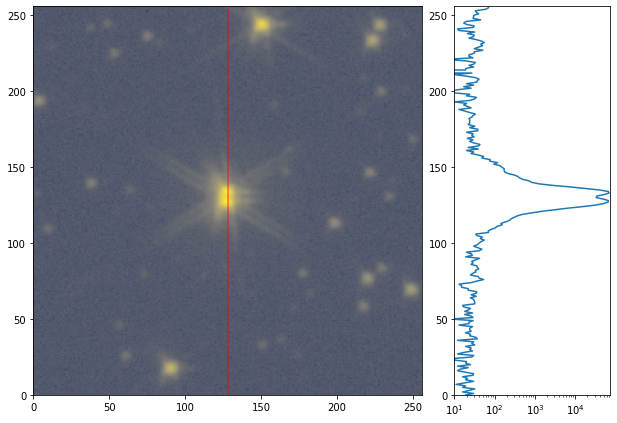

In [5]:
fig = plt.figure(figsize=(9,10))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cmap = plt.get_cmap('cividis')
ax.imshow(pixels_final-np.min(pixels_final)+1,interpolation=None,cmap=cmap,norm=LogNorm())
ax.plot(np.zeros(2)+pars.xout/2,[0,pars.yout],c='r',ls='solid',zorder=10,alpha=0.5)
ax.set_xlim([0,pars.xout])
ax.set_ylim([0,pars.yout])

xi = int(pars.xout/2)
ax2.plot(pixels_final[:,xi]-np.min(pixels_final[:,xi]),np.arange(pars.xout),c='tab:blue')
ax2.set_ylim([0,pars.yout])
xlim = np.array(ax2.get_xlim())
xlim[0] = 10
ax2.set_xlim(xlim)
ax2.set_xscale('log')

ax_pos = ax.get_position()
ax_pos.x0 = 0.1
ax_pos.x1 = 0.7
ax_pos.y0 = 0.1
ax_pos.y1 = 0.99
ax.set_position(ax_pos)

ax_pos = ax.get_position()
ax2_pos = ax2.get_position()
ax2_pos.x0 = np.copy(ax_pos.x1) + 0.05
ax2_pos.x1 = 0.99
ax2_pos.y0 = np.copy(ax_pos.y0)
ax2_pos.y1 = np.copy(ax_pos.y1)
ax2.set_position(ax2_pos)